# Virus spread

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [1]:
# Model design
import agentpy as ap
import networkx as nx 
import random 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

In [2]:
class Person(ap.Agent):
    
    def setup(self):  
        """ Initialize a new variable at agent creation. """
        self.condition = 0  # Susceptible = 0, Infected = 1, Recovered = 2
        
    def being_sick(self):
        """ Spread disease to peers in the network. """
        for n in self.neighbors(): 
            if n.condition == 0 and self.p.infection_chance > random.random():
                n.condition = 1  # Infect susceptible peer
        if self.p.recovery_chance > random.random(): 
            self.condition = 2  # Recover from infection

In [3]:
class VirusModel(ap.Model):
    
    def setup(self):
        """ Initialize the agents and network of the model. """
        
        # Prepare a small-world network
        graph = nx.watts_strogatz_graph(
            self.p.population, 
            self.p.number_of_neighbors, 
            self.p.network_randomness)
        
        # Create agents and network
        self.add_agents(self.p.population, Person)
        self.add_network(graph=graph, agents=self.agents)
        
        # Infect a random share of the population
        I0 = int(self.p.initial_infection_share * self.p.population)
        self.agents.random(I0).condition = 1 

    def update(self):  
        """ Record variables after setup and each step. """
        
        # Record share of agents with each condition
        for i, c in enumerate(('S', 'I', 'R')):
            n_agents = len(self.agents.select(self.agents.condition == i))
            self[c] = n_agents / self.p.population 
            self.record(c)
        
        # Stop simulation if disease is gone
        if self.I == 0:
            self.stop()
        
    def step(self):   
        """ Define the models' events per simulation step. """
        
        # Call 'being_sick' for infected agents
        self.agents.select(self.agents.condition == 1).being_sick()
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
        
        # Record final evaluation measures
        self.measure('Total share infected', self.I + self.R) 
        self.measure('Peak share infected', max(self.log['I']))

## Running a simulation

In [4]:
parameters = {  
    'population': 1000,
    'infection_chance': 0.3,
    'recovery_chance': 0.1,
    'initial_infection_share': 0.1,
    'number_of_neighbors': 2,
    'network_randomness': 0.5   
}

model = VirusModel(parameters)
results = model.run() 

Completed: 76 steps
Run time: 0:00:00.345242
Simulation finished


## Analyzing results

In [5]:
results

DataDict {
'log': Dictionary with 4 keys
'parameters': Dictionary with 6 keys
'measures': DataFrame with 2 variables and 1 row
'variables': DataFrame with 3 variables and 77 rows
}

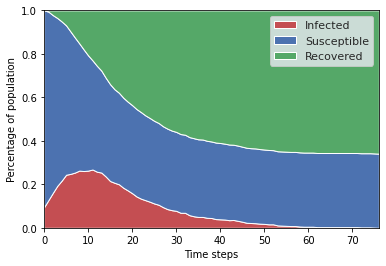

In [6]:
def virus_stackplot(data, ax):
    """ Stackplot of people's condition over time. """
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I', 'S', 'R']]
    
    sns.set()
    ax.stackplot(x, y, labels=['Infected', 'Susceptible', 'Recovered'],
                 colors = ['r', 'b', 'g'])    
    
    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")

fig, ax = plt.subplots()
virus_stackplot(results.variables, ax)

## Creating an animation

In [7]:
def animation_plot(m, axs):
    ax1, ax2 = axs
    ax1.set_title("Virus spread")
    ax2.set_title(f"Share infected: {m.I}")
    
    # Plot stackplot on first axis
    virus_stackplot(m.output.variables, ax1)
    
    # Plot network on second axis
    color_dict = {0:'b', 1:'r', 2:'g'}
    colors = [color_dict[c] for c in m.agents.condition]
    nx.draw_circular(m.env.graph, node_color=colors, 
                     node_size=50, ax=ax2)

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) # Prepare figure 
parameters['population'] = 50 # Lower population for better visibility 
animation = ap.animate(VirusModel(parameters), fig, axs, animation_plot)

Using Jupyter, we can display this animation directly in our notebook.

In [8]:
IPython.display.HTML(animation.to_jshtml()) 

## Interactive parameter variation

In [9]:
param_ranges = {
    'population':(100, 1000),
    'infection_chance':(0.1, 1.),
    'recovery_chance':(0.1, 1.),
    'initial_infection_share':0.1,
    'number_of_neighbors':2,
    'network_randomness':(0., 1.)
}

sample = ap.sample_saltelli(param_ranges, n=100, digits=2)

In [10]:
def interactive_plot(m):
    fig,ax = plt.subplots()
    virus_stackplot(m.output.variables, ax)
    
exp = ap.Experiment(VirusModel, sample)
exp.interactive(interactive_plot)

(This interactive plot is not visible within the agentpy documentation. You can download a Jupyter notebook of this demonstration a the top of this page to try it out.)

## Multi-run experiment

In [11]:
exp = ap.Experiment(VirusModel, sample)
results = exp.run()

Scheduled runs: 600
Completed: 600, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:55.022950


Optionally, we can save and load our results as follows:

In [12]:
results.save()

Data saved to ap_output/VirusModel_1


In [13]:
results = ap.load('VirusModel')

Loading from directory ap_output/VirusModel_1/
Loading parameters_varied.csv - Successful
Loading parameters_fixed.json - Successful
Loading log.json - Successful
Loading measures.csv - Successful


In [14]:
print(results)

DataDict {
'parameters': 
    'varied': DataFrame with 4 variables and 600 rows
    'fixed': Dictionary with 2 keys
'log': Dictionary with 5 keys
'measures': DataFrame with 2 variables and 600 rows
}


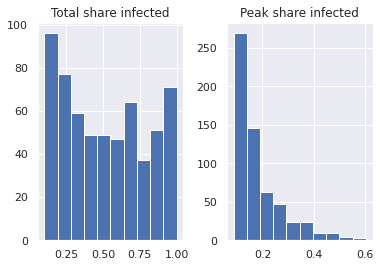

In [15]:
results.measures.hist()
plt.show()

## Sensitivity analysis

In [16]:
ap.sensitivity_sobol(results, param_ranges)

DataDict {
'parameters': 
    'varied': DataFrame with 4 variables and 600 rows
    'fixed': Dictionary with 2 keys
'log': Dictionary with 5 keys
'measures': DataFrame with 2 variables and 600 rows
'sensitivity': DataFrame with 2 variables and 8 rows
'sensitivity_conf': DataFrame with 2 variables and 8 rows
}

In [17]:
results.sensitivity

S1        ST
measure              parameter                             
Total share infected population          0.013304  0.033427
                     infection_chance    0.759380  0.850658
                     recovery_chance     0.094885  0.188086
                     network_randomness  0.004253  0.036266
Peak share infected  population          0.007470  0.043532
                     infection_chance    0.359025  0.558792
                     recovery_chance     0.507005  0.685053
                     network_randomness  0.036194  0.058734

We can use pandas to create a bar plot that visualizes these sensitivity indices.

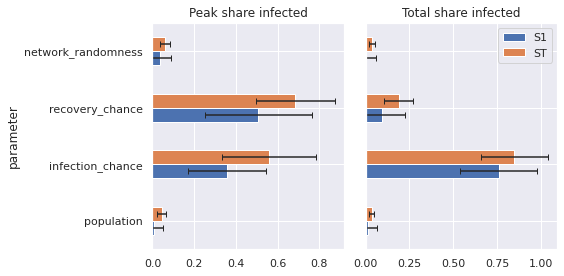

In [18]:
def plot_sobol(results):
    """ Bar plot of Sobol sensitivity indices. """
    
    sns.set()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    si_list = results.sensitivity.groupby(by='measure')
    si_conf_list = results.sensitivity_conf.groupby(by='measure')

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):
        si = si.droplevel('measure')
        err = err.droplevel('measure')
        si.plot.barh(xerr=err, title=key, ax=ax, capsize = 3)
        ax.set_xlim(0)
    
    axs[0].get_legend().remove()
    axs[1].set(ylabel=None, yticklabels=[]) 
    axs[1].tick_params(left=False)
    plt.tight_layout()
    
plot_sobol(results)

Alternatively, we can also display sensitivities by plotting 
average evaluation measures over our parameter variations. 

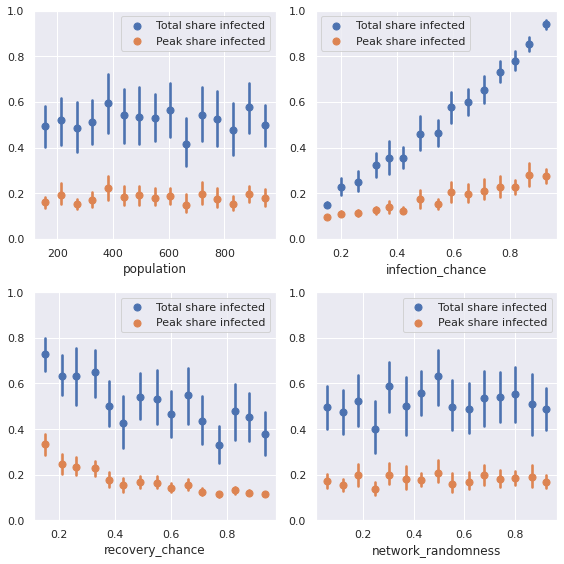

In [19]:
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """
    
    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = [i for j in axs for i in j] # Flatten list
    
    data = results.arrange_measures() 
    params = results.parameters.varied.keys() 
    
    for x, ax in zip(params, axs):
        for y in results.measures.columns:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99, 
                        x_bins=15, fit_reg=False, label=y)  
        ax.set_ylim(0,1)
        ax.set_ylabel('')
        ax.legend()
        
    plt.tight_layout()

plot_sensitivity(results)